In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt

In [2]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
portfolio_kwargs = dict(
    direction='all',  # long and short
    freq='d'
)
windows = np.arange(10, 50)

In [3]:
price = vbt.utils.data.download('BTC-USD', period='max')['Close']

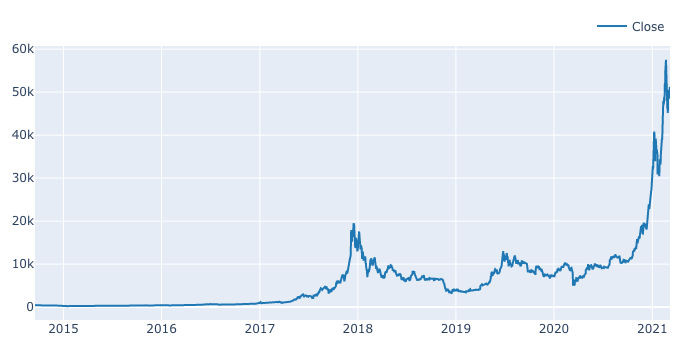

In [4]:
price.vbt.plot().show_png()

In [5]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

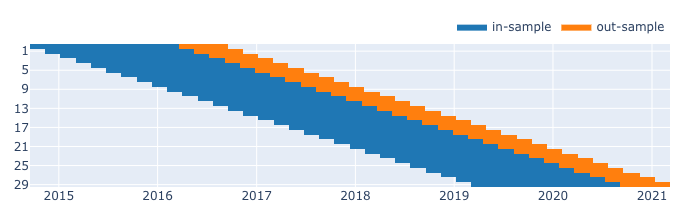

In [6]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show_png()

In [7]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [8]:
def simulate_holding(price, **kwargs):
    portfolio = vbt.Portfolio.from_holding(price, **kwargs)
    return portfolio.sharpe_ratio()

In [9]:
in_hold_sharpe = simulate_holding(in_price, **portfolio_kwargs)

print(in_hold_sharpe)

split_idx
0     0.229171
1     0.396165
2     1.144520
3     1.229957
4     1.634736
5     1.893314
6     2.091598
7     2.018062
8     2.328099
9     2.600494
10    2.589374
11    3.029547
12    2.627654
13    2.411702
14    2.227228
15    1.842043
16    1.648943
17    1.568284
18    0.743785
19    0.429000
20    0.355126
21   -0.212305
22    0.855325
23    0.435844
24    0.374935
25    0.333268
26    0.371117
27    0.849220
28    1.130929
29    1.249801
Name: sharpe_ratio, dtype: float64


In [10]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(price, windows, r=2, short_names=['fast', 'slow'])
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [11]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **portfolio_kwargs)

print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            0.856870
                          1            1.015869
                          2            0.186511
                          3            0.309808
                          4            0.586081
                                         ...   
48           49           25           1.838769
                          26           1.004767
                          27           0.039117
                          28           0.018551
                          29          -0.542958
Name: sharpe_ratio, Length: 23400, dtype: float64


In [12]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [13]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(27, 29,  0),
            (27, 29,  1),
            (21, 25,  2),
            (23, 25,  3),
            (23, 25,  4),
            (23, 25,  5),
            (41, 42,  6),
            (40, 43,  7),
            (31, 45,  8),
            (10, 21,  9),
            (10, 21, 10),
            (10, 21, 11),
            (10, 21, 12),
            (10, 21, 13),
            (10, 21, 14),
            (10, 21, 15),
            (10, 22, 16),
            (10, 22, 17),
            (10, 26, 18),
            (10, 22, 19),
            (17, 22, 20),
            (18, 21, 21),
            (13, 21, 22),
            (13, 21, 23),
            (18, 21, 24),
            (18, 21, 25),
            (18, 21, 26),
            (13, 21, 27),
            (15, 18, 28),
            (13, 20, 29)],
           names=['fast_window', 'slow_window', 'split_idx'])


In [14]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [15]:
in_best_fast_windows = get_best_params(in_best_index, 'fast_window')
in_best_slow_windows = get_best_params(in_best_index, 'slow_window')
in_best_window_pairs = np.array(list(zip(in_best_fast_windows, in_best_slow_windows)))

print(in_best_window_pairs)

[[27 29]
 [27 29]
 [21 25]
 [23 25]
 [23 25]
 [23 25]
 [41 42]
 [40 43]
 [31 45]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 21]
 [10 22]
 [10 22]
 [10 26]
 [10 22]
 [17 22]
 [18 21]
 [13 21]
 [13 21]
 [18 21]
 [18 21]
 [18 21]
 [13 21]
 [15 18]
 [13 20]]


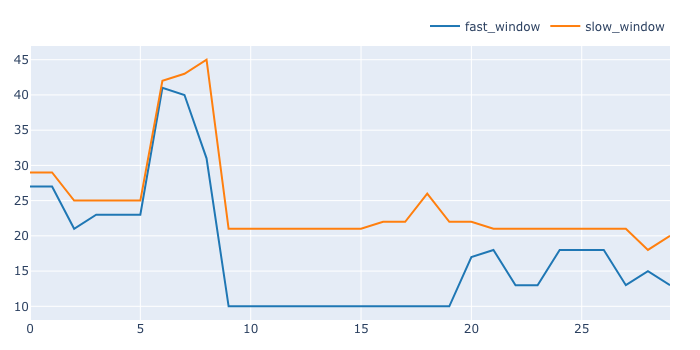

In [16]:
pd.DataFrame(in_best_window_pairs, columns=['fast_window', 'slow_window']).vbt.plot().show_png()

In [17]:
out_hold_sharpe = simulate_holding(out_price, **portfolio_kwargs)

print(out_hold_sharpe)

split_idx
0     1.773721
1     1.984613
2     2.410545
3     3.267779
4     2.360511
5     3.401232
6     3.636305
7     3.890343
8     3.853553
9     2.328501
10    1.408759
11    0.044008
12   -0.587022
13   -0.657871
14   -0.806785
15   -1.025927
16   -1.504820
17   -0.260930
18    3.932827
19    2.913997
20    1.515515
21   -0.112145
22   -0.653178
23   -0.018756
24    1.016650
25    0.796429
26    2.271581
27    2.518017
28    4.909425
29    4.674980
Name: sharpe_ratio, dtype: float64


In [18]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **portfolio_kwargs)

print(out_sharpe)

fast_window  slow_window  split_idx
10           11           0           -1.018512
                          1           -1.278942
                          2            2.216261
                          3            0.718590
                          4            1.564312
                                         ...   
48           49           25          -2.116894
                          26          -1.187642
                          27          -1.809777
                          28           2.384623
                          29           4.199280
Name: sharpe_ratio, Length: 23400, dtype: float64


In [19]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    fast_ma = vbt.MA.run(out_price, window=best_fast_windows, per_column=True)
    slow_ma = vbt.MA.run(out_price, window=best_slow_windows, per_column=True)
    entries = fast_ma.ma_above(slow_ma, crossover=True)
    exits = fast_ma.ma_below(slow_ma, crossover=True)
    portfolio = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return portfolio.sharpe_ratio()

In [20]:
# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_fast_windows, in_best_slow_windows, **portfolio_kwargs)

print(out_test_sharpe)

ma_window  ma_window  split_idx
27         29         0            1.164082
                      1            0.445859
21         25         2            2.276335
23         25         3            1.952444
                      4            0.315346
                      5            1.976118
41         42         6            0.495150
40         43         7           -1.780946
31         45         8            1.179479
10         21         9            3.576386
                      10           2.974144
                      11           0.918114
                      12           0.157251
                      13           0.047807
                      14           0.278384
                      15           0.183469
           22         16           0.742635
                      17           1.539349
           26         18           2.941490
           22         19           0.638254
17         22         20           0.219740
18         21         21           1.850448


In [21]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values
})

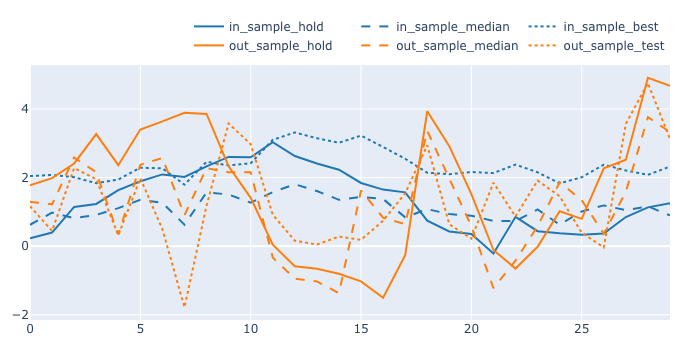

In [23]:
cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=vbt.settings.color_schema['blue']),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['blue'], line_dash='dot'),
        dict(line_color=vbt.settings.color_schema['orange']),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dash'),
        dict(line_color=vbt.settings.color_schema['orange'], line_dash='dot')
    ]
).show_png()